## Project 3 MVP

### Import Modules and Settings

In [203]:
import spotify_modeling as sp
import os
import path

import numpy as np
import pandas as pd
pd.set_option("display.max_rows", 500)
pd.set_option("display.precision", 3)
pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:.3f}".format
import pandas_profiling

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline
import seaborn as sns
sns.set(context="notebook", style="darkgrid", rc={"figure.facecolor":"white"}, font_scale= 1.2)

from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict, KFold, StratifiedKFold, learning_curve, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder, normalize, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, auc, fbeta_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)
warnings.filterwarnings("ignore", category = FutureWarning)

random_state = 98924

spotify_data = 'spotify_analysis.pickle'
album_data = 'spotify_album_analysis.pickle'
album_data_v2 = 'album_df_additional_genre_cleaning'

path = os.getcwd() + '/data/'
raw_path = path + 'raw/'
billboard_path = path + 'external/billboard_weeks/'
fuzzy_path = path + 'interim/'
model_path = path + 'model/'

### Problem

**Using the Spotipy package, I'm extracting a set of 'audio features' that are provided by Spotify's Web API in order to predict if a song will be 'successful'.**  

**Use**: In today's digital age the barrier to releasing songs has become almost trivial, but this has also led to an exponential increase in the 'noise'. One of the largest entries to barriers in into the music industry is getting noticed. Although it's no guarantee of sustained success, being able to produce a top 'hit' goes a long way towards getting your foot in the door. By using Spotify's audio features to create a model, I will provide recommendations for emerging artists and their producers on features to focus on that will most likely get them noticed. 

**Progress**: I am currently looking at which features and models have the best predictive capabilities and will be likely be looking at the F1 score as a measure given that both precision and recall are important for my question.

### Variable Descriptions

#### Feature Descriptions

**Description of features as provided by Spotify. Any features on a continuous scale from 0-1 were multiplied by 100 to provide easier readability.**   
* **acousticness**: a confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.  
* **danceability**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.  
* **energy**: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
* **instrumentalness**: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
* **key**: The key the track is in. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on.
* **liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
* **loudness**: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.
* **mode**: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
* **speechiness**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
* **tempo**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
* **valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

**Will not include but plotting for EDA**
* **popularity**: The popularity of the track. The value will be between 0 and 100, with 100 being the most popular. The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity. Note that the popularity value may lag actual popularity by a few days: the value is not updated in real time.

**Additional features to incorporate after MVP**
* **Genre**: I suspect that the inclusion of genre will contribute to a decent increase in model accuracy. It's clear that certain genres of music (i.e pop, hip-hop) tend to dominate the charts these days. Because I am only including a subset of songs from 2018 (some bleedover from 2017 and into 2019), genre should be an important predictor.
* **Presence**: Would like to bring in a factor to measure the 'clout' of the artist. Well-known artist do not need to spend as much effort to get people to listen to their music. 

#### Target Description

* **success**: The target for my problem is classifying if a song is 'successful' (1) or not (0). To determine this metric, I scraped the songs listed on the Hot 100 for each week from 01/06/18 to 06/29/19. There are 955 unique entries after removing duplicates. This dataframe was then merged into the main dataframe obtained from the Spotify Web API, resulting in 407 matches for 'successful' songs.  

**Additional improvements after MVP**: Would like to hone the merging process for matching the spotify_df and billboard_df. Current process is using FuzzyWuzzy package with a threshold of 88 which may not necessarily capture all of the matches. I would also like to increase the count of my positive class by incoporating lists of songs from other sources such as Spotify's own year-end top 100 lists. 

### Exploratory Data Analysis

In [204]:
spotify_df = pd.read_pickle(model_path + album_data)
#spotify_df = pd.read_pickle(model_path + album_data_v2)

In [ ]:
spotify_df.profile_report()

In [205]:
features = ['danceability', 'energy', 'loudness', 'tempo','instrumentalness','key','liveness','mode','valence', 'acousticness', 'pop',
            'rap', 'hip-hop', 'country', 'electronic', 'rock','indie', 'house', 'metal', 'jazz', 'soul', 'reggaeton', 'other', 'minutes']
plotting_features = ['success','danceability', 'energy', 'loudness', 'tempo', 'valence', 'instrumentalness', 
                     'key', 'liveness', 'acousticness', 'valence']
y = spotify_df['success']
X = spotify_df.loc[:,features]

# Used for different processing of genres
#features = ['danceability', 'energy', 'loudness', 'tempo','instrumentalness','key','liveness','mode','valence', 'speechiness', 'acousticness', 'pop',
#            'rap/hip-hop', 'edm', 'rock','jazz','other', 'indie', 'minutes']
#plotting_features = ['success', 'danceability', 'energy', 'loudness', 'instrumentalness', 'tempo']
#y = spotify_df['success']
#X = spotify_df.loc[:,features]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, 
                                                    random_state = random_state,
                                                    stratify = y)

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = .25,
                                            random_state = random_state,
                                            stratify = y_train)

### Basic EDA Visualizations

In [ ]:
spotify_df.corr()

In [ ]:
sns.stripplot(x = 'energy',y = 'success', jitter = True, data = spotify_df[plotting_features] ,alpha=0.6);

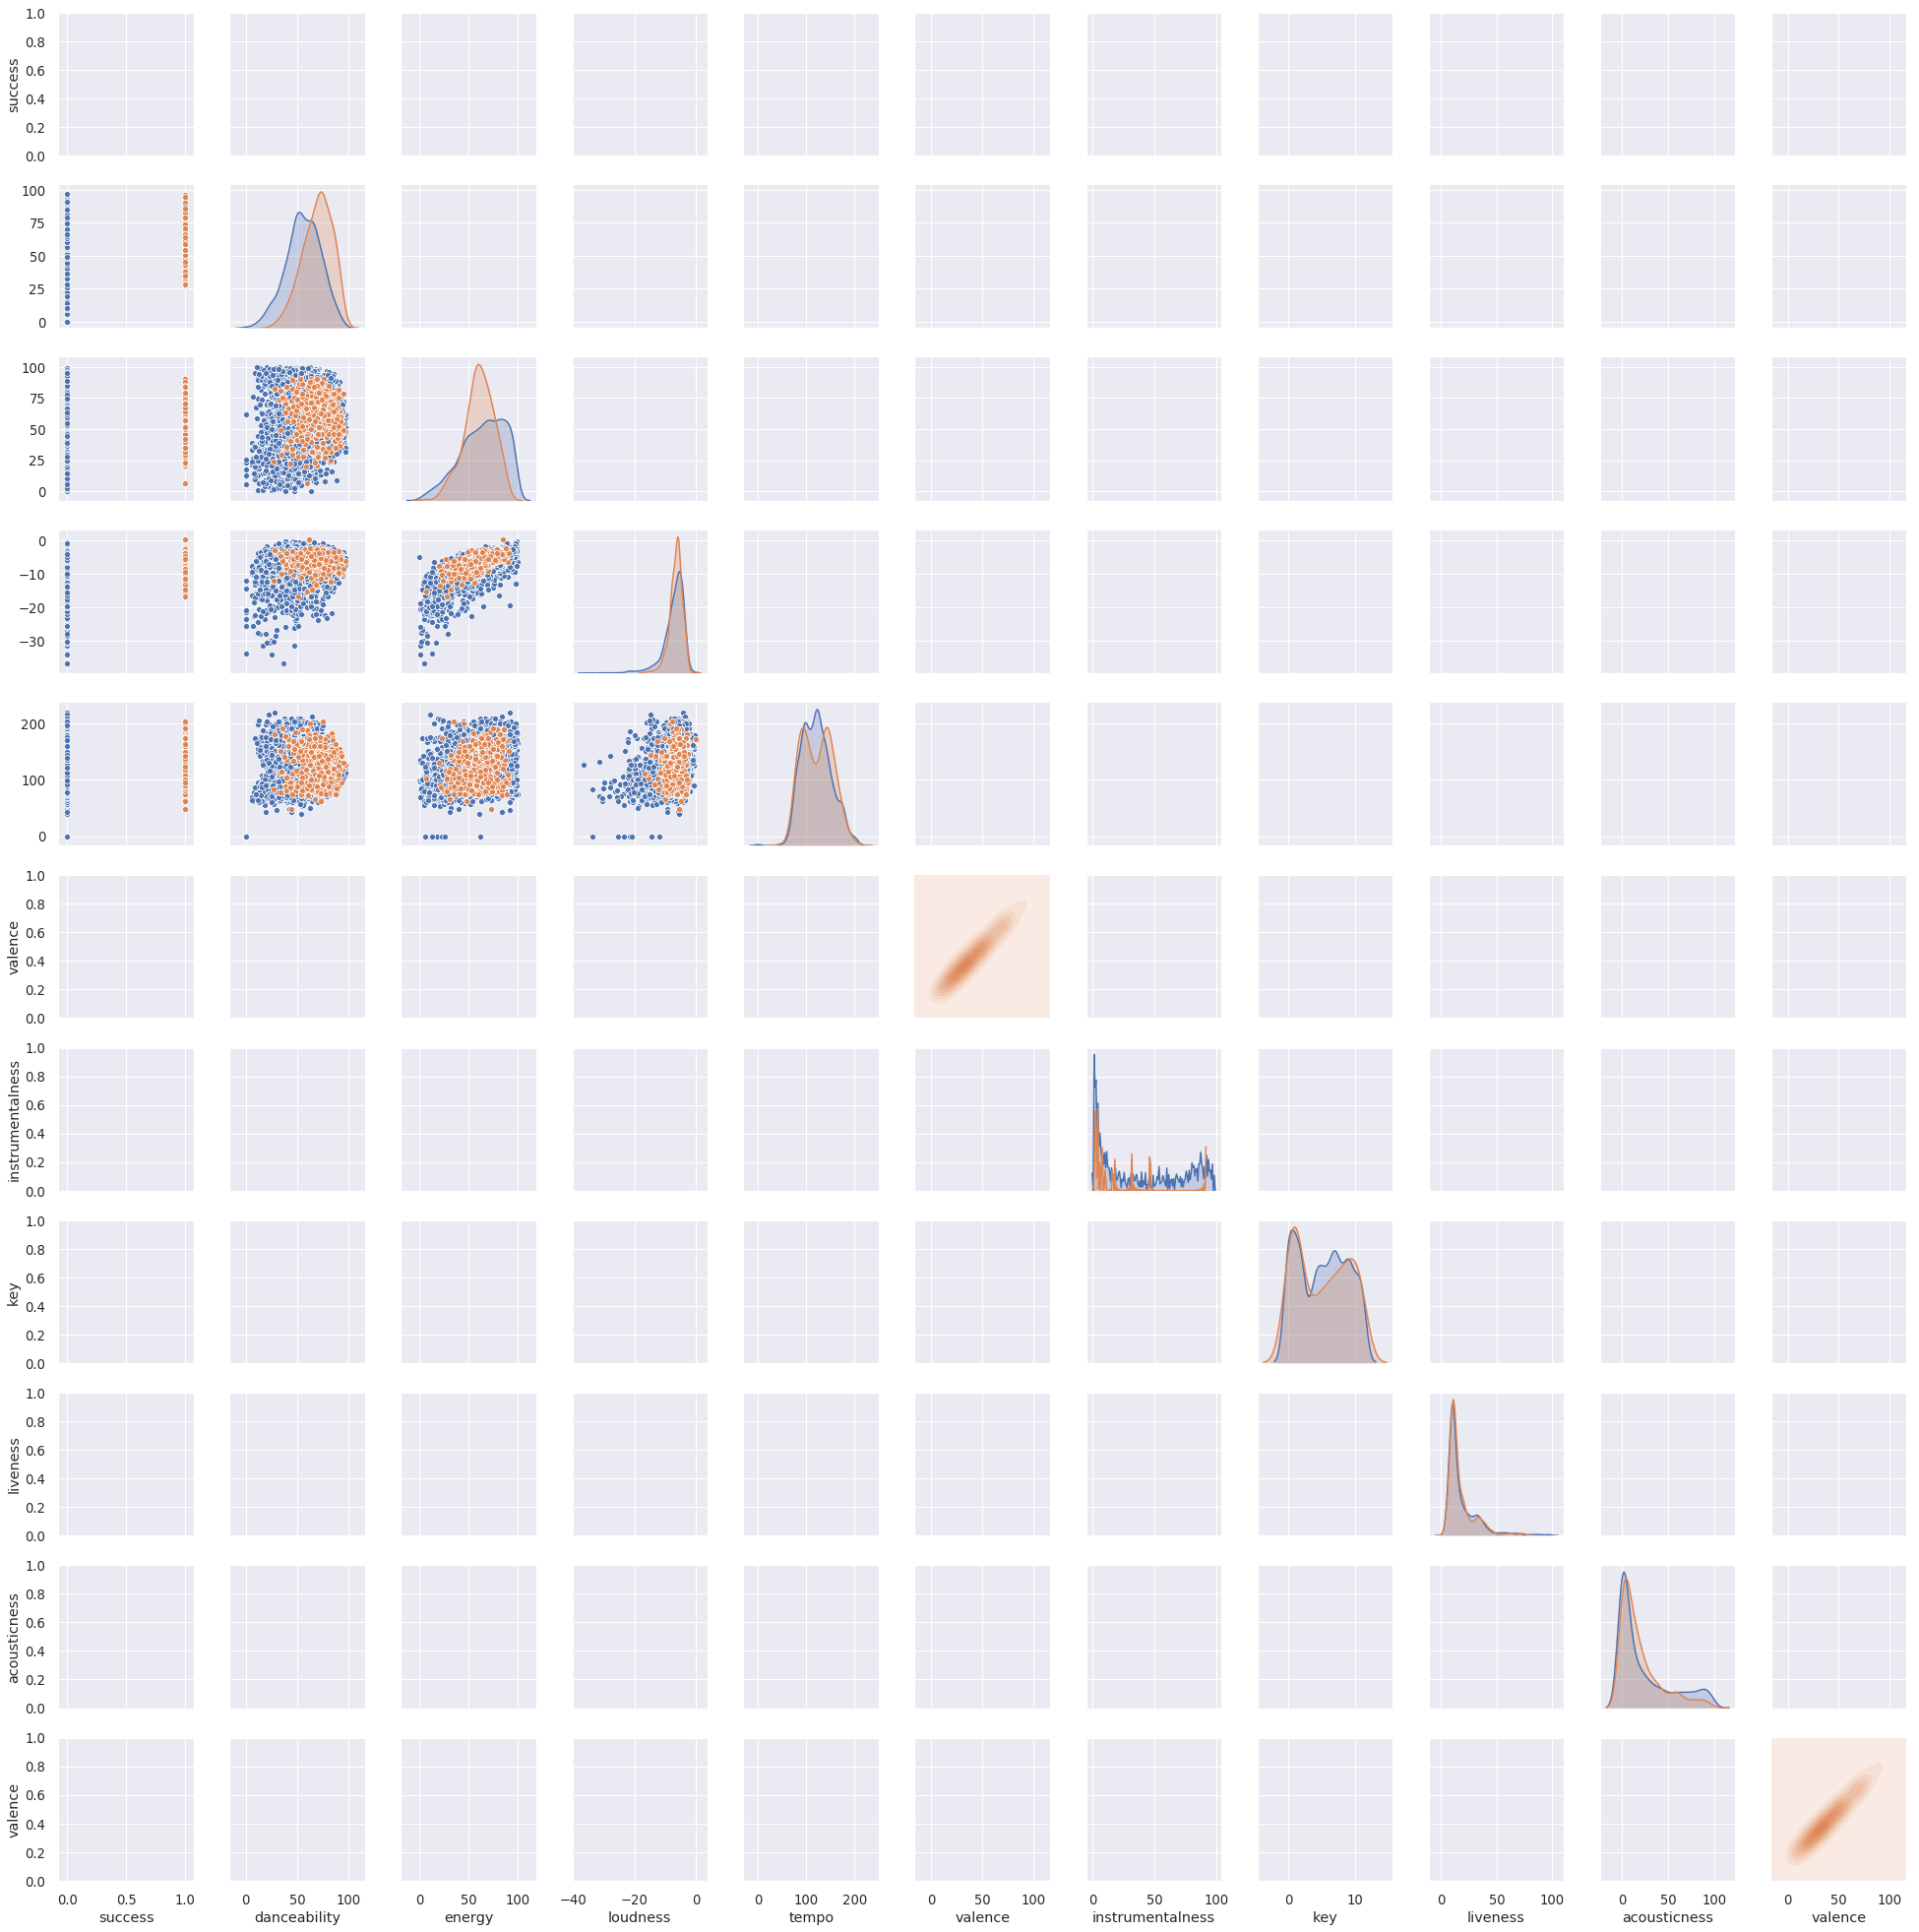

In [190]:
sns.pairplot(spotify_df[plotting_features], hue = 'success')
sns.set(context="notebook", style="darkgrid", rc={"figure.facecolor":"white"}, font_scale= 1.2)

### Models

#### Functions

In [30]:
# Create functions to do cross validation on the training set of data for different models

def cross_metrics_simple(n_folds, X_train, y_train):
    '''
    Function that outputs the 4 scoring metrics: [accuracy, precision, recall, and f1]
        for each of the classifiers in list clf_models
    args:
        n_folds: enter number of cross validation folds to test on. Integer value defaults to StratifiedKFolds
        X_train: Features separate from the hold-out/test set
        y_train: Predictor class separate from the hold-out/test set
    '''
    clf_models = [
        LogisticRegression(),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        GaussianNB(),

    ]

    for clf in clf_models:
        pipe = Pipeline([('scalar', StandardScaler()),
                         ('clf', clf)
                        ])
    
        print(type(clf).__name__,'Cross Validation Scores')
        print('Accuracy : {:4.6f}'.format(np.mean(cross_val_score(pipe, X_train, y_train, cv = n_folds, scoring = 'accuracy'))))  
        print('Precision: {:4.6f}'.format(np.mean(cross_val_score(pipe, X_train, y_train, cv = n_folds, scoring = 'precision'))))
        print('Recall   : {:4.6f}'.format(np.mean(cross_val_score(pipe, X_train, y_train, cv = n_folds, scoring = 'recall'))))
        print('F1 Score : {:4.6f}'.format(np.mean(cross_val_score(pipe, X_train, y_train, cv = n_folds, scoring = 'f1'))),'\n')
    return None


def cross_metrics_detailed(n_folds, X_train, y_train):
    '''
    Function that outputs the 4 scoring metrics: [accuracy, precision, recall, and f1]
        for each of the classifiers in list clf_models. Lists metrics for both the test and training set
        along with the fit and score times for each model
    args:
        n_folds: enter number of cross validation folds to test on. Integer value defaults to StratifiedKFolds
        X_train: Features separate from the hold-out/test set
        y_train: Predictor class separate from the hold-out/test set
    '''
    
    clf_models = [
        LogisticRegression(),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        GaussianNB()    
    ]

    for clf in clf_models:
        pipe = Pipeline([('scalar', StandardScaler()),
                         ('clf', clf)
                        ])
    
        print(type(clf).__name__,'Cross Validation Scores')
        print(pd.DataFrame(cross_validate(clf, X_train, y_train, cv = n_folds, scoring = ['accuracy', 'precision', 'recall', 'f1'],
                                          return_train_score = True)).mean(),'\n')
    return None


def cross_metrics_poly(n_folds, poly_deg, X_train, y_train):
    '''
    Function that outputs the 4 scoring metrics: [accuracy, precision, recall, and f1]
        for each of the classifiers in list clf_models
    args:
        n_folds: enter number of cross validation folds to test on. Integer value defaults to StratifiedKFolds
        X_train: Features separate from the hold-out/test set
        y_train: Predictor class separate from the hold-out/test set
    '''
    clf_models = [
        LogisticRegression(),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        SVC(),
        GaussianNB()    
    ]

    for clf in clf_models:
        pipe = Pipeline([('polynomial', PolynomialFeatures(degree = poly_deg)),
                         ('scalar', StandardScaler()),
                         ('clf', clf)
                        ])
    
        print(type(clf).__name__,'Cross Validation Scores')
        print('Accuracy : {:4.6f}'.format(np.mean(cross_val_score(pipe, X_train, y_train, cv = n_folds, scoring = 'accuracy'))))  
        print('Precision: {:4.6f}'.format(np.mean(cross_val_score(pipe, X_train, y_train, cv = n_folds, scoring = 'precision'))))
        print('Recall   : {:4.6f}'.format(np.mean(cross_val_score(pipe, X_train, y_train, cv = n_folds, scoring = 'recall'))))
        print('F1 Score : {:4.6f}'.format(np.mean(cross_val_score(pipe, X_train, y_train, cv = n_folds, scoring = 'f1'))),'\n')
    return None

#### Cross Validation

In [92]:
y_train.value_counts()

0    3988
1     326
Name: success, dtype: int64

In [93]:
cross_metrics_simple(3, X_train, y_train)

LogisticRegression Cross Validation Scores
Accuracy : 0.923041
Precision: 0.298148
Recall   : 0.018377
F1 Score : 0.034399 

DecisionTreeClassifier Cross Validation Scores
Accuracy : 0.880623
Precision: 0.227204
Recall   : 0.245583
F1 Score : 0.239485 

RandomForestClassifier Cross Validation Scores
Accuracy : 0.920492
Precision: 0.323418
Recall   : 0.055159
F1 Score : 0.095199 

GaussianNB Cross Validation Scores
Accuracy : 0.515082
Precision: 0.131214
Recall   : 0.960103
F1 Score : 0.230804 



In [32]:
sp.cross_metrics_detailed(3, X_train, y_train)

LogisticRegression Cross Validation Scores
fit_time          0.052
score_time        0.007
test_accuracy     0.922
train_accuracy    0.924
test_precision    0.214
train_precision   0.425
test_recall       0.009
train_recall      0.020
test_f1           0.017
train_f1          0.037
dtype: float64 

DecisionTreeClassifier Cross Validation Scores
fit_time          0.028
score_time        0.009
test_accuracy     0.877
train_accuracy    1.000
test_precision    0.213
train_precision   1.000
test_recall       0.236
train_recall      1.000
test_f1           0.224
train_f1          1.000
dtype: float64 

RandomForestClassifier Cross Validation Scores
fit_time          0.047
score_time        0.024
test_accuracy     0.923
train_accuracy    0.988
test_precision    0.428
train_precision   1.000
test_recall       0.077
train_recall      0.845
test_f1           0.130
train_f1          0.916
dtype: float64 

GaussianNB Cross Validation Scores
fit_time          0.007
score_time        0.010
test_accu

In [ ]:
# Just for curiosity
#sp.cross_metrics_poly(5, 3, X, y)

#### Logistic Regression Model with Hyperparameter Tuning

In [192]:
# Logistic Regression with parameter tuning
pipe = Pipeline([
    ('scalar', StandardScaler()),
    ('clf', LogisticRegression())
])

#print(type(pipe[1]).__name__, 'Model')
print('Optimal Parameters:')
parameters =  {
    'clf__C': [0.001, 0.01, .05, 0.1, 0.5, 1, 10, 100, 1000],
    'clf__class_weight': [{1:2, 0:1}, {1:3, 0:1},
                          {1:4, 0:1}, {1:5, 0:1},
                          {1:6, 0:1}, {1:7, 0:1},
                          'balanced']    
}

grid = GridSearchCV(pipe, param_grid = parameters, cv = 10, scoring = 'f1', return_train_score = True)
grid.fit(X_train, y_train)
grid_y_predict = pd.Series(grid.predict(X_test))

print(grid.best_params_,'\n')
print('Accuracy  : {:4.6f}'.format(accuracy_score(y_test, grid_y_predict)))
print('Precision : {:4.6f}'.format(precision_score(y_test, grid_y_predict)))
print('Recall    : {:4.6f}'.format(recall_score(y_test, grid_y_predict)))
print('F1 Score  : {:4.6f}'.format(f1_score(y_test, grid_y_predict)))
print('FB Score  : {:4.6f}'.format(fbeta_score(y_test, grid_y_predict, average = 'binary', beta = 2)))

Optimal Parameters:
{'clf__C': 0.01, 'clf__class_weight': {1: 4, 0: 1}} 

Accuracy  : 0.873957
Precision : 0.339181
Recall    : 0.716049
F1 Score  : 0.460317
FB Score  : 0.585859


#### Logistic Regression (No Scaling)

In [176]:
lgr = LogisticRegression(C = .01, class_weight = {0:1, 1:4}, random_state = 6)

lgr.fit(X_tr, y_tr)

lgr_y_tr_predict = lgr.predict(X_tr)
lgr_y_val_predict = lgr.predict(X_val)

print('Training Set:')
print('Accuracy  : {:4.6f}'.format(accuracy_score(y_tr, lgr_y_tr_predict)))
print('Precision : {:4.6f}'.format(precision_score(y_tr, lgr_y_tr_predict)))
print('Recall    : {:4.6f}'.format(recall_score(y_tr, lgr_y_tr_predict)))
print('F1 Score  : {:4.6f}'.format(f1_score(y_tr, lgr_y_tr_predict)))
print('FB Score  : {:4.6f}'.format(fbeta_score(y_tr, lgr_y_tr_predict, average = 'binary', beta = 2)),'\n')

print('Validation Set:')
print('Accuracy  : {:4.6f}'.format(accuracy_score(y_val, lgr_y_val_predict)))
print('Precision : {:4.6f}'.format(precision_score(y_val, lgr_y_val_predict)))
print('Recall    : {:4.6f}'.format(recall_score(y_val, lgr_y_val_predict)))
print('F1 Score  : {:4.6f}'.format(f1_score(y_val, lgr_y_val_predict)))
print('FB Score  : {:4.6f}'.format(fbeta_score(y_val, lgr_y_val_predict, average = 'binary', beta = 2)),'\n')

Training Set:
Accuracy  : 0.887172
Precision : 0.318318
Recall    : 0.434426
F1 Score  : 0.367418
FB Score  : 0.404889 

Validation Set:
Accuracy  : 0.895273
Precision : 0.336842
Recall    : 0.390244
F1 Score  : 0.361582
FB Score  : 0.378251 



In [177]:
lgr_y_test_predict = lgr.predict(X_test)
print('Test Set:')
print('Accuracy  : {:4.6f}'.format(accuracy_score(y_test, lgr_y_test_predict)))
print('Precision : {:4.6f}'.format(precision_score(y_test, lgr_y_test_predict)))
print('Recall    : {:4.6f}'.format(recall_score(y_test, lgr_y_test_predict)))
print('F1 Score  : {:4.6f}'.format(f1_score(y_test, lgr_y_test_predict)))
print('FB Score  : {:4.6f}'.format(fbeta_score(y_test, lgr_y_test_predict, average = 'binary', beta = 2)))

Test Set:
Accuracy  : 0.885079
Precision : 0.325203
Recall    : 0.493827
F1 Score  : 0.392157
FB Score  : 0.447427


#### Logistic Regression (Standard Scaled)

In [195]:
# Train on training set and test on validation set
scalar = StandardScaler()
lgr = LogisticRegression(C = .01, class_weight = {0:1, 1:4}, random_state = 6)

X_tr_scaled = scalar.fit_transform(X_tr)
lgr.fit(X_tr_scaled, y_tr)
X_val_scaled =  scalar.transform(X_val)

lgr_y_tr_predict = lgr.predict(X_tr_scaled)
lgr_y_val_predict = lgr.predict(X_val_scaled)

print('Training Set:')
print('Accuracy  : {:4.6f}'.format(accuracy_score(y_tr, lgr_y_tr_predict)))
print('Precision : {:4.6f}'.format(precision_score(y_tr, lgr_y_tr_predict)))
print('Recall    : {:4.6f}'.format(recall_score(y_tr, lgr_y_tr_predict)))
print('F1 Score  : {:4.6f}'.format(f1_score(y_tr, lgr_y_tr_predict)))
print('FB Score  : {:4.6f}'.format(fbeta_score(y_tr, lgr_y_tr_predict, average = 'binary', beta = 2)),'\n')

print('Validation Set:')
print('Accuracy  : {:4.6f}'.format(accuracy_score(y_val, lgr_y_val_predict)))
print('Precision : {:4.6f}'.format(precision_score(y_val, lgr_y_val_predict)))
print('Recall    : {:4.6f}'.format(recall_score(y_val, lgr_y_val_predict)))
print('F1 Score  : {:4.6f}'.format(f1_score(y_val, lgr_y_val_predict)))
print('FB Score  : {:4.6f}'.format(fbeta_score(y_val, lgr_y_val_predict, average = 'binary', beta = 2)),'\n')

Training Set:
Accuracy  : 0.865224
Precision : 0.322222
Recall    : 0.713115
F1 Score  : 0.443878
FB Score  : 0.573879 

Validation Set:
Accuracy  : 0.844300
Precision : 0.285000
Recall    : 0.695122
F1 Score  : 0.404255
FB Score  : 0.539773 



In [196]:
# Scoring on hold-out/test set
X_te_scaled = scalar.transform(X_test)
lgr_y_test_predict = lgr.predict(X_te_scaled)
print('Test Set:')
print('Accuracy  : {:4.6f}'.format(accuracy_score(y_test, lgr_y_test_predict)))
print('Precision : {:4.6f}'.format(precision_score(y_test, lgr_y_test_predict)))
print('Recall    : {:4.6f}'.format(recall_score(y_test, lgr_y_test_predict)))
print('F1 Score  : {:4.6f}'.format(f1_score(y_test, lgr_y_test_predict)))
print('FB Score  : {:4.6f}'.format(fbeta_score(y_test, lgr_y_test_predict, average = 'binary', beta = 2)))

Test Set:
Accuracy  : 0.866543
Precision : 0.324022
Recall    : 0.716049
F1 Score  : 0.446154
FB Score  : 0.576541


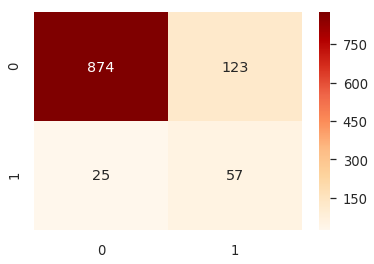

In [45]:
sns.heatmap(confusion_matrix(y_val, lgr_y_val_predict), cmap = 'OrRd', annot = True, fmt = '2.0f')
sns.set(context="notebook", style="darkgrid", rc={"figure.facecolor":"white"}, font_scale= 1.2)

#### Decision Tree Classifier

In [ ]:
# Train on training set and test on validation set
tree = DecisionTreeClassifier(class_weight = {0:1, 1:4}, min_samples_leaf = 10, max_depth = 10,
                              min_samples_split = 10, random_state = 5)
tree.fit(X_tr, y_tr)
tree_y_tr_predict = tree.predict(X_tr)
tree_y_val_predict = tree.predict(X_val)

print('Training Set:')
print('Accuracy  : {:4.6f}'.format(accuracy_score(y_tr, tree_y_tr_predict)))
print('Precision : {:4.6f}'.format(precision_score(y_tr, tree_y_tr_predict)))
print('Recall    : {:4.6f}'.format(recall_score(y_tr, tree_y_tr_predict)))
print('F1 Score  : {:4.6f}'.format(f1_score(y_tr, tree_y_tr_predict)),'\n')

print('Validation Set:')
print('Accuracy  : {:4.6f}'.format(accuracy_score(y_val, tree_y_val_predict)))
print('Precision : {:4.6f}'.format(precision_score(y_val, tree_y_val_predict)))
print('Recall    : {:4.6f}'.format(recall_score(y_val, tree_y_val_predict)))
print('F1 Score  : {:4.6f}'.format(f1_score(y_val, tree_y_val_predict)),'\n')

In [ ]:
# Score on hold-out/test set
tree_y_test_predict = tree.predict(X_test)
print('Test Set:')
print('Accuracy  : {:4.6f}'.format(accuracy_score(y_test, tree_y_test_predict)))
print('Precision : {:4.6f}'.format(precision_score(y_test, tree_y_test_predict)))
print('Recall    : {:4.6f}'.format(recall_score(y_test, tree_y_test_predict)))
print('F1 Score  : {:4.6f}'.format(f1_score(y_test, tree_y_test_predict)))

#### RandomForest Classifier 

In [206]:
forest = RandomForestClassifier(n_estimators = 300, max_features = 4, class_weight = {0:1, 1:7},
                                min_samples_leaf = 10, max_depth = 10, min_samples_split = 10, random_state = 5 )

forest.fit(X_tr, y_tr)
forest_y_tr_predict = forest.predict(X_tr)
forest_y_val_predict = forest.predict(X_val)

forest_probs_val = forest.predict_proba(X_val)[:,1]

print('Training Set:')
print('Accuracy  : {:4.6f}'.format(accuracy_score(y_tr, forest_y_tr_predict)))
print('Precision : {:4.6f}'.format(precision_score(y_tr, forest_y_tr_predict)))
print('Recall    : {:4.6f}'.format(recall_score(y_tr, forest_y_tr_predict)))
print('F1 Score  : {:4.6f}'.format(f1_score(y_tr, forest_y_tr_predict)))
print('FB Score  : {:4.6f}'.format(fbeta_score(y_tr, forest_y_tr_predict, average = 'binary', beta = 2)),'\n') 

print('Validation Set:')
print('Accuracy  : {:4.6f}'.format(accuracy_score(y_val, forest_y_val_predict)))
print('Precision : {:4.6f}'.format(precision_score(y_val, forest_y_val_predict)))
print('Recall    : {:4.6f}'.format(recall_score(y_val, forest_y_val_predict)))
print('F1 Score  : {:4.6f}'.format(f1_score(y_val, forest_y_val_predict)))
print('FB Score  : {:4.6f}'.format(fbeta_score(y_val, forest_y_val_predict, average = 'binary', beta = 2))) 

Training Set:
Accuracy  : 0.889954
Precision : 0.380342
Recall    : 0.729508
F1 Score  : 0.500000
FB Score  : 0.616343 

Validation Set:
Accuracy  : 0.876738
Precision : 0.339623
Recall    : 0.658537
F1 Score  : 0.448133
FB Score  : 0.554415


In [207]:
# Scoring on hold-out/test set
forest_y_test_predict = forest.predict(X_test)
print('Test Set:')
print('Accuracy  : {:4.6f}'.format(accuracy_score(y_test, forest_y_test_predict)))
print('Precision : {:4.6f}'.format(precision_score(y_test, forest_y_test_predict)))
print('Recall    : {:4.6f}'.format(recall_score(y_test, forest_y_test_predict)))
print('F1 Score  : {:4.6f}'.format(f1_score(y_test, forest_y_test_predict)))
print('FB Score  : {:4.6f}'.format(fbeta_score(y_test, forest_y_test_predict, average = 'binary', beta = 2))) 

Test Set:
Accuracy  : 0.886006
Precision : 0.361842
Recall    : 0.679012
F1 Score  : 0.472103
FB Score  : 0.577731


In [212]:
pd.DataFrame({'Variable': X_tr.columns,
              'Importance': forest.feature_importances_}).sort_values('Importance', ascending = False)

,Variable,Importance
11,rap,0.222
0,danceability,0.102
15,rock,0.082
12,hip-hop,0.078
4,instrumentalness,0.075
1,energy,0.067
9,acousticness,0.053
23,minutes,0.050
2,loudness,0.047
8,valence,0.041


In [211]:
features

['danceability',
 'energy',
 'loudness',
 'tempo',
 'instrumentalness',
 'key',
 'liveness',
 'mode',
 'valence',
 'acousticness',
 'pop',
 'rap',
 'hip-hop',
 'country',
 'electronic',
 'rock',
 'indie',
 'house',
 'metal',
 'jazz',
 'soul',
 'reggaeton',
 'other',
 'minutes']

In [210]:
for feature in zip(features, forest.feature_importances_):
    print(feature)

('danceability', 0.1022153076179313)
('energy', 0.06697170805402626)
('loudness', 0.04692991711880165)
('tempo', 0.040526023639255185)
('instrumentalness', 0.07508368496592886)
('key', 0.021044300442612716)
('liveness', 0.03369761049614127)
('mode', 0.004626129160755394)
('valence', 0.04066880423372687)
('acousticness', 0.052768662705577334)
('pop', 0.008988255117829119)
('rap', 0.2215089149033554)
('hip-hop', 0.07780469121689801)
('country', 0.006322081643876763)
('electronic', 0.0016784173923807262)
('rock', 0.08181381886031934)
('indie', 0.03513337359980128)
('house', 0.0026564755058689177)
('metal', 0.010095007462668509)
('jazz', 0.0)
('soul', 0.005673683903425206)
('reggaeton', 0.0007150130232730622)
('other', 0.012763596083670168)
('minutes', 0.05031452285187686)


In [ ]:
# Random Forest Classifier - Issues getting it to run quickly 
forest_clf = RandomForestClassifier()

#print(type(forest_clf[1]).__name__)
#print('Optimal Parameters:')
parameters =  {
    'n_estimators': [300],
    'min_samples_leaf': [9, 10, 11],
    'class_weight': [{0:1, 1:4}, {0:1, 1:5}, {0:1, 1:6}],
    'max_depth': [9, 10, 11],
    'min_samples_split': [9, 10, 11]
}

grid = GridSearchCV(forest_clf, param_grid = parameters, cv = 3)
grid.fit(X_train, y_train)
#grid.score(X_test, y_test)
grid_y_predict = grid.predict(X_test)

#print(grid.best_params_,'\n')
print('Accuracy  : {:4.6f}'.format(accuracy_score(y_test, grid_y_predict)))
print('Precision : {:4.6f}'.format(precision_score(y_test, grid_y_predict)))
print('Recall    : {:4.6f}'.format(recall_score(y_test, grid_y_predict)))
print('F1 Score  : {:4.6f}'.format(f1_score(y_test, grid_y_predict)))
print('FB Score  : {:4.6f}'.format(fbeta_score(y_test, grid_y_predict, average = 'binary', beta = 2)), '\n') 

#### Extra Tree

In [115]:
extra_tree = ExtraTreeClassifier(class_weight = {0:1, 1:6}, max_features = 7, min_samples_leaf = 8,
                                 max_depth = 8, min_samples_split = 10, random_state = 5)
extra_tree.fit(X_tr, y_tr)
extra_tree_y_tr_pre = extra_tree.predict(X_tr)
extra_tree_y_val_pre = extra_tree.predict(X_val) 

print('Extra Tree Training Set:')
print('Accuracy  : {:4.6f}'.format(accuracy_score(y_tr, extra_tree_y_tr_pre)))
print('Precision : {:4.6f}'.format(precision_score(y_tr, extra_tree_y_tr_pre)))
print('Recall    : {:4.6f}'.format(recall_score(y_tr, extra_tree_y_tr_pre)))
print('F1 Score  : {:4.6f}'.format(f1_score(y_tr, extra_tree_y_tr_pre)))
print('FB Score  : {:4.6f}'.format(fbeta_score(y_tr, extra_tree_y_tr_pre, average = 'binary', beta = 2)), '\n') 

print('Extra Tree Validation Set:')
print('Accuracy  : {:4.6f}'.format(accuracy_score(y_val, extra_tree_y_val_pre)))
print('Precision : {:4.6f}'.format(precision_score(y_val, extra_tree_y_val_pre)))
print('Recall    : {:4.6f}'.format(recall_score(y_val, extra_tree_y_val_pre)))
print('F1 Score  : {:4.6f}'.format(f1_score(y_val, extra_tree_y_val_pre)))
print('FB Score  : {:4.6f}'.format(fbeta_score(y_val, extra_tree_y_val_pre, average = 'binary', beta = 2)), '\n') 

Extra Tree Training Set:
Accuracy  : 0.851932
Precision : 0.297064
Recall    : 0.704918
F1 Score  : 0.417983
FB Score  : 0.553055 

Extra Tree Validation Set:
Accuracy  : 0.864690
Precision : 0.318182
Recall    : 0.682927
F1 Score  : 0.434109
FB Score  : 0.555556 



In [116]:
extra_tree_y_te_pre = extra_tree.predict(X_test)

print('Extra Tree Test Set:')
print('Accuracy  : {:4.6f}'.format(accuracy_score(y_test, extra_tree_y_te_pre)))
print('Precision : {:4.6f}'.format(precision_score(y_test, extra_tree_y_te_pre)))
print('Recall    : {:4.6f}'.format(recall_score(y_test, extra_tree_y_te_pre)))
print('F1 Score  : {:4.6f}'.format(f1_score(y_test, extra_tree_y_te_pre)))
print('FB Score  : {:4.6f}'.format(fbeta_score(y_test, extra_tree_y_te_pre, average = 'binary', beta = 2)), '\n') 

Extra Tree Test Set:
Accuracy  : 0.861909
Precision : 0.326531
Recall    : 0.790123
F1 Score  : 0.462094
FB Score  : 0.615385 



#### XGBoost

In [117]:
xg = XGBClassifier(n_estimators = 400, scale_pos_weight = 6, learning_rate = .0001, max_depth = 8,
                   random_state = 5, booster = 'dart')
xg.fit(X_tr, y_tr)
xg_y_tr_predict = forest.predict(X_tr)
xg_y_val_predict = forest.predict(X_val)

print('Training Set:')
print('Accuracy  : {:4.6f}'.format(accuracy_score(y_tr, xg_y_tr_predict)))
print('Precision : {:4.6f}'.format(precision_score(y_tr, xg_y_tr_predict)))
print('Recall    : {:4.6f}'.format(recall_score(y_tr, xg_y_tr_predict)))
print('F1 Score  : {:4.6f}'.format(f1_score(y_tr, xg_y_tr_predict)))
print('FB Score  : {:4.6f}'.format(fbeta_score(y_tr, xg_y_tr_predict, average = 'binary', beta = 2)), '\n') 

print('Validation Set:')
print('Accuracy  : {:4.6f}'.format(accuracy_score(y_val, xg_y_val_predict)))
print('Precision : {:4.6f}'.format(precision_score(y_val, xg_y_val_predict)))
print('Recall    : {:4.6f}'.format(recall_score(y_val, xg_y_val_predict)))
print('F1 Score  : {:4.6f}'.format(f1_score(y_val, xg_y_val_predict)))
print('FB Score  : {:4.6f}'.format(fbeta_score(y_val, xg_y_val_predict, average = 'binary', beta = 2)), '\n')

Training Set:
Accuracy  : 0.886862
Precision : 0.371308
Recall    : 0.721311
F1 Score  : 0.490251
FB Score  : 0.606897 

Validation Set:
Accuracy  : 0.879518
Precision : 0.328571
Recall    : 0.560976
F1 Score  : 0.414414
FB Score  : 0.491453 



In [118]:
xg_y_te_pre = xg.predict(X_test)

print('Extra Tree Test Set:')
print('Accuracy  : {:4.6f}'.format(accuracy_score(y_test, xg_y_te_pre)))
print('Precision : {:4.6f}'.format(precision_score(y_test, xg_y_te_pre)))
print('Recall    : {:4.6f}'.format(recall_score(y_test, xg_y_te_pre)))
print('F1 Score  : {:4.6f}'.format(f1_score(y_test, xg_y_te_pre)))
print('FB Score  : {:4.6f}'.format(fbeta_score(y_test, xg_y_te_pre, average = 'binary', beta = 2)), '\n')

Extra Tree Test Set:
Accuracy  : 0.845227
Precision : 0.282828
Recall    : 0.691358
F1 Score  : 0.401434
FB Score  : 0.536398 



In [ ]:
#fig, ax = plt.subplots(figsize=(12,18))
#xgb.plot_importance(xg.get_booster(), height=0.8, importance_type= 'gain', ax = ax).set_yticklabels(X_hr_cont.columns)
#plt.show()

#### Gaussian Naive Bayes

In [59]:
gnb = GaussianNB()
gnb.fit(X_tr, y_tr)
gnb_y_tr_predict = gnb.predict(X_tr)
gnb_y_val_predict = gnb.predict(X_val)

print('Gaussian Naive Bayes Training Set:')
print('Accuracy  : {:4.6f}'.format(accuracy_score(y_tr, gnb_y_tr_predict)))
print('Precision : {:4.6f}'.format(precision_score(y_tr, gnb_y_tr_predict)))
print('Recall    : {:4.6f}'.format(recall_score(y_tr, gnb_y_tr_predict)))
print('F1 Score  : {:4.6f}'.format(f1_score(y_tr, gnb_y_tr_predict)),'\n')

print('Gaussian Naive Bayes Validation Set:')
print('Accuracy  : {:4.6f}'.format(accuracy_score(y_val, gnb_y_val_predict)))
print('Precision : {:4.6f}'.format(precision_score(y_val, gnb_y_val_predict)))
print('Recall    : {:4.6f}'.format(recall_score(y_val, gnb_y_val_predict)))
print('F1 Score  : {:4.6f}'.format(f1_score(y_val, gnb_y_val_predict)),'\n')

Gaussian Naive Bayes Training Set:
Accuracy  : 0.553941
Precision : 0.141662
Recall    : 0.971311
F1 Score  : 0.247261 

Gaussian Naive Bayes Validation Set:
Accuracy  : 0.531974
Precision : 0.133449
Recall    : 0.939024
F1 Score  : 0.233687 



In [60]:
# Scoring on hold-out/test set
gnb_y_test_predict = gnb.predict(X_test)
print('Test Set:')
print('Accuracy  : {:4.6f}'.format(accuracy_score(y_test, gnb_y_test_predict)))
print('Precision : {:4.6f}'.format(precision_score(y_test, gnb_y_test_predict)))
print('Recall    : {:4.6f}'.format(recall_score(y_test, gnb_y_test_predict)))
print('F1 Score  : {:4.6f}'.format(f1_score(y_test, gnb_y_test_predict)))

Test Set:
Accuracy  : 0.537535
Precision : 0.135889
Recall    : 0.962963
F1 Score  : 0.238168


# Model Results

#### Confusion Matrix

In [75]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap = 'ocean_r')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix: Random Forest Model', pad = 25)
    
    return fig

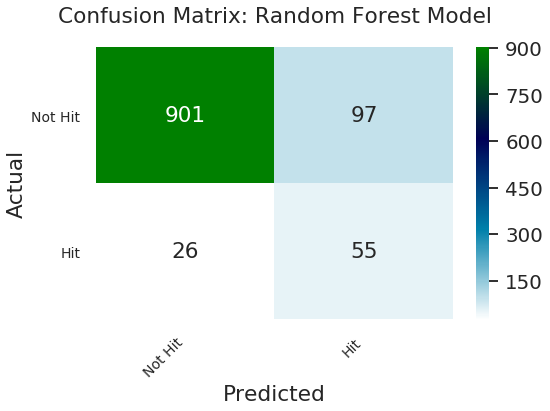

In [77]:
conf = confusion_matrix(y_test, forest_y_test_predict)
print_confusion_matrix(conf, ['Not Hit','Hit'], figsize = (8,5), fontsize=14)
sns.set(context="talk", style="darkgrid", rc={"figure.facecolor":"gray",
                                              'axes.labelcolor':'white',
                                              "figure.edgecolor":"white",
                                              'text.color':'white',
                                              'hatch.color' : 'white',
                                               'legend.edgecolor': 'white'}, font_scale= 1.2)

In [ ]:
print_confusion_matrix(conf, ['Not Hit','Hit'], figsize = (10,7), fontsize=14)

In [ ]:
sns.heatmap(confusion_matrix(y_test, forest_y_test_predict), cmap = 'RdBu', annot = True, fmt = '3g')
sns.set(context="talk", style="darkgrid", rc={"figure.facecolor":"white"}, font_scale= 1.2)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [ ]:
#dummy threshold
thresh_ps = np.linspace(.10,.7,1000)
#predicting probabilities
forest_val_probs = forest.predict_proba(X_val)[:,1]
f1_scores = []
for p in thresh_ps:
    forest_val_labels = forest_val_probs >= p
    f1_scores.append(f1_score(y_val, forest_val_labels))
    
plt.plot(thresh_ps, f1_scores)
plt.title('F1 Score vs. Positive Class Decision Probability Threshold')
plt.xlabel('P threshold')
plt.ylabel('F1 score')
best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]
print('Random forest Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

In [ ]:
#dummy threshold
thresh_ps = np.linspace(.10,.7,1000)
#predicting probabilities
forest_val_probs = forest.predict_proba(X_val)[:,1]
recall_scores = []
for p in thresh_ps:
    forest_val_labels = forest_val_probs >= p
    recall_scores.append(recall_score(y_val, forest_val_labels))
    
plt.plot(thresh_ps, recall_scores)
plt.title('Recall Score vs. Positive Class Decision Probability Threshold')
plt.xlabel('P Threshold')
plt.ylabel('Recall Score')
best_recall_score = np.max(recall_scores) 
best_thresh_p = thresh_ps[np.argmax(recall_scores)]
print('Random forest Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_recall_score, best_thresh_p))

In [ ]:
#dummy threshold
thresh_ps = np.linspace(.10,.7,1000)
#predicting probabilities
forest_val_probs = forest.predict_proba(X_val)[:,1]
precision_scores = []
for p in thresh_ps:
    forest_val_labels = forest_val_probs >= p
    precision_scores.append(precision_score(y_val, forest_val_labels))
plt.plot(thresh_ps, recall_scores)    
plt.plot(thresh_ps, precision_scores)
plt.title('Precision Score vs. Positive Class Decision Probability Threshold')
plt.xlabel('P Threshold')
plt.ylabel('Precision Score')
best_precision_score = np.max(precision_scores) 
best_thresh_p = thresh_ps[np.argmax(precision_scores)]
print('Random forest Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_precision_score, best_thresh_p))

#### ROC-AUC Curve

In [ ]:
#ROC-AUC Curve
forest_probs_val = forest.predict_proba(X_val)[:,1]
fpr = dict()
tpr = dict()
fpr, tpr, _ = roc_curve(y_val, forest_probs_val)

roc_auc = dict()
roc_auc = round(auc(fpr, tpr),5)

plt.figure(figsize = (10, 10))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC Curve', fontweight = 'bold', fontsize = 20)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.plot(fpr, tpr, label = 'AUC = {}'.format(roc_auc))
plt.legend(loc = 'lower right', shadow = True, fancybox = True)
plt.legend()
plt.show()